# Steps Involved in Selecting a Model For a Small Data-set

In my article on the [Steps Involved in Selecting a Model](#). I talked about the difference between small and large datasets and their importance in model selection. I also talked about how to perform model selection and evaluation on them.

This notebook addresses means to select a model for a small dataset.

The dataset we'll be making use of will be the [iris dataset](https://www.lac.inpe.br/~rafael.santos/Docs/CAP394/WholeStory-Iris.html), It is a perfect example of a small dataset. The measures I describe from my article are:

1.	Transform categorical columns to numeric (If any)
2.	Perform a k-fold cross-validation
3.	Elect candidate models
4.	Split k-fold to train and test folds
5.	Model evaluation on train folds
6.	model evaluation on test fold(s)
7.	Model selection

### Transform categorical columns to numeric

Machine learning models are unable to interpret non-numeric values, so to work with machine learning (ML) models, all non-numeric columns need to be transformed to numeric values.

In most cases, feature columns that would need to be transformed to numeric values would be categorical columns like `[low, medium, high]` or `[Yes, No]` or `[Male, Female]`.

Sklearn as a toolbox was built to handle these conversions: they include the `LabelEncoder`, `OrdinalEncoder`, `OneHotEncoder`, e.t.c. All this is available in `sklearn.preprocessing`.

> Resources to articles that provides clarification on these tools can be found in the further reading section of this article.

In our case though, all columns are perfectly numeric (continuous) so we wouldn't be applying any here.


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score

In [2]:
dataset = load_iris()
data, target = dataset.data, dataset.target

### Perform a k-fold cross-validation

The k-fold cross-validation is a procedure used to estimate the skill of the model on new data. [machinelearningmastery](https://machinelearningmastery.com/k-fold-cross-validation/).

![KFold Cross Validation](images/kfold-re.png)
<p align="center"><b>KFold Cross validation</b></p>

K-fold cross validating works by splitting the dataset to a specified number of folds (say 5) and then shifting the position of the test set to a single fold at each iteration (as described above). 

After performing the K-fold cross-validation, we then end up with the N number of the same dataset with N different training and testing sets (where N is the number of splits applied on the dataset).

In [3]:
iris_kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [4]:
kf_data_list = [
    (
        data[train_index],
        data[test_index],
        target[train_index],
        target[test_index]
    )
    for train_index, test_index in iris_kf.split(data, target)
]

The purpose of performing k-fold cross-validation is to expand the dataset.

What do I mean by this? The iris dataset for has a total of 150 data which is so small that extracting a test set will leave us with very little to train with.

By splitting the dataset into a training and test set across 5 different instances, we try to maximize the use of the available data for training and testing the model.

### Elect candidate models

Now that we've successfully split our dataset in 5 K-Folds, we can proceed to elect the candidate models. We look at the kind of task we are solving and the models that can solve/address it.

In [5]:
print(dataset.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

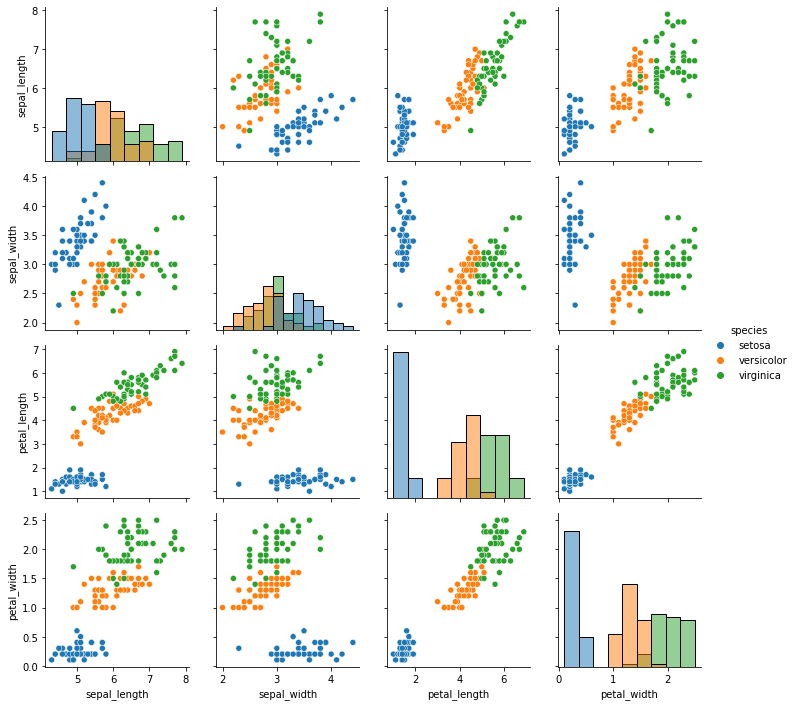

In [6]:
# Code by seaborn at
# https://seaborn.pydata.org/tutorial/axis_grids.html

iris = sns.load_dataset("iris")
g = sns.PairGrid(iris, hue="species")

g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

The Iris dataset is a classification task. It has four (4) feature columns which are `sepal length (cm)`, `sepal width (cm)`, `petal length (cm)` and `petal width (cm)`. All are continuous feature columns.

By visualizing the dataset, we can tell that the `petal width (cm)`, and `petal length (cm)` feature column is linearly separable from the other feature columns. Well, this and probably more relationships. 

Question: What models best decide these relationships?

> I’ll go straight to listing out models that can determine these relationships. For more on the reasons we picked the models check out the further reading section.

We'll be electing the `LogisticRegression`, `SVC`, `KNN`, and `RandomForestClassifier`.

### Perform Model Evaluation

Now that we've decided on the machine learning (ML) models, we can proceed to evaluate the models with our dataset using cross-validation.

We would make use of the [`sklearn.model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) to cross-validate the dataset and get the scores on the model performance across each fold.

In [7]:
def model_performance(data, target, *models):
    """
    Takes a record of the model performance during cross validation
    
    returns the record of the model performance along with the 
            model performance rating of the stating which model performed 
            best and which performed worst
    """
    
    record = {
        'Logistic Regression': {},
        'K-Nearest Neighbor': {},
        'Random Forest Classifier': {},
        'Support Vector Classifier': {},
    }
    
    avg_model_performance = []
    
    for model, name in zip(models, record.keys()):
        scores = cross_val_score(model, data, target, cv=5, scoring='accuracy')
        
        record[name]['scores'] = scores
        record[name]['mean_score'] = scores.mean()
        avg_model_performance.append((round(float(scores.mean()) * 100, 2), name))
    
    record['Model Performance Rating'] = sorted(avg_model_performance, reverse=True)
    
    return record

In [8]:
record = model_performance(data, target, LogisticRegression(max_iter=1000), KNeighborsClassifier(), RandomForestClassifier(), SVC())

In [9]:
for model in list(record.keys())[:-1]:
    print(model, record[model])

Logistic Regression {'scores': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ]), 'mean_score': 0.9733333333333334}
K-Nearest Neighbor {'scores': array([0.96666667, 1.        , 0.93333333, 0.96666667, 1.        ]), 'mean_score': 0.9733333333333334}
Random Forest Classifier {'scores': array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ]), 'mean_score': 0.96}
Support Vector Classifier {'scores': array([0.96666667, 0.96666667, 0.96666667, 0.93333333, 1.        ]), 'mean_score': 0.9666666666666666}


In [10]:
# Best Performing Models

record['Model Performance Rating']

[(97.33, 'Logistic Regression'),
 (97.33, 'K-Nearest Neighbor'),
 (96.67, 'Support Vector Classifier'),
 (96.0, 'Random Forest Classifier')]

### Model Selection

After cross-validating the dataset we can now conclude that the best performing models are the Logistic Regression and the K-Nearest Neighbor models which both had an accuracy of 97.33%. 

This implies that either of them would be efficient for deployment. Now based on the needs of the problem, we can decide on either of the models. 

If you have needs for a model-based learning algorithm, you can choose the KNN or the Logistic Regression for instance-based learning.

### Conclusion

In conclusion, after cross-validation and testing, you are provided with a lot of information to select your model. Our technique (cross-validating) mainly works for small datasets like our example. The case is different for a larger dataset though.

> if you try to process a small data set naively, it will still work. If you try to process a large data set naively, it will take orders of magnitude longer than acceptable (and possibly exhaust your computing resources as well). ~[Carlos Barge](https://www.bi.wygroup.net/digital-transformation/what-is-the-difference-between-big-data-large-data-set-data-stream-and-streaming-data/)

For a larger dataset, the process of splitting the dataset into a train, dev (cross-validation), and test set would prove crucial. It would be computationally expensive to try cross-validating the dataset as we did with the iris-dataset.

### Further Reading

Encoding Categorical Columns

- [Encoding Categorical data in Machine Learning](https://medium.com/bycodegarage/encoding-categorical-data-in-machine-learning-def03ccfbf40)
- [Guide to Encoding Categorical Features Using Scikit-Learn For Machine Learning](https://towardsdatascience.com/guide-to-encoding-categorical-features-using-scikit-learn-for-machine-learning-5048997a5c79)

Scikit-Learn Models

- [Support Vector Machine](https://en.wikipedia.org/wiki/Support-vector_machine)
- [Random Forest](https://en.wikipedia.org/wiki/Random_forest)
- [K-Nearest Neighbor](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
- [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)

Further Reading On Model Selection

- [A “short” introduction to model selection](https://towardsdatascience.com/a-short-introduction-to-model-selection-bb1bb9c73376)
- [A Gentle Introduction to Model Selection for Machine Learning](https://machinelearningmastery.com/a-gentle-introduction-to-model-selection-for-machine-learning/)

Associated Notebooks

- [Steps Involved in Selecting a Model For a larger Data-set](https://www.kaggle.com/ganiyuolalekan/model-selection-for-larger-dataset)

Book

- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

